# Shock waves in Burger's equation

We will now look at solutions to [Burger's equation](https://en.wikipedia.org/wiki/Burgers%27_equation):

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$

We can investigate this with the following methods:

- [FTCS](https://en.wikipedia.org/wiki/FTCS_scheme)
- [Lax](https://en.wikipedia.org/wiki/Lax–Friedrichs_method)
- [Godunov](https://en.wikipedia.org/wiki/Godunov%27s_scheme)

The FTCS step will be entirely unstable (as you can guess from previous exercises). The Lax method will be stable, but artificially decay prematurely. The Godunov method, on the other hand, will stably simulate the shock wave conserving flux. 

In [1]:


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import numpy as np
import math

In [2]:

class Burgers :

    def __init__(self, N=500, L=1.0, CFL_ratio=1.0, method="Godunov") : 
        self.L = L                         # size of periodic region
        self.N = N                         # number of grid points
        self.dx = L / float(N)             # lattice spacing
        self.t = 0.0                       # time
        self.CFL_ratio = CFL_ratio         # Courant-Friedrichs-Lewy ratio
        self.dt = CFL_ratio * self.dx      # time step
        self.initial_waveform = "Sine"

        self.nu = 1.0e-6                   # kinematic viscosity

        self.method = method               # integration method
        self.step = 0                      # integration step number
        # create arrays for lattice vectors
        self.u = np.zeros(N)
        self.u_new = np.zeros(N)
        self.x = np.arange(N) * self.dx

        # reset lattice spacing and initialize waveform
        self.dx = L / float(N)
        if self.initial_waveform == "Sine":
            self.u = np.sin(2 * np.pi * self.x) + 0.5 * np.sin(np.pi * self.x)
        elif self.initial_waveform == "Step":
            self.u = np.where( (self.x>0.25*L) & (self.x<0.75*L), 1.0, 0.0 )
        self.u_max = max( np.abs(self.u) )

        # set time, step and step number
        self.t = 0.0
        self.dt = self.CFL_ratio * self.dx / self.u_max
        self.step = 0

        self.T = 1.0                 # time to travel length L
        self.frames_per_sec = 25     # animation rate for screen redraws
        

    def FTCS(self):
        self.u_new[:] = self.u * (1.0 - self.dt / (2.0 * self.dx) *  (np.roll(self.u,-1) - np.roll(self.u,1)) )
        self.u_new[:] += self.nu * self.dt / self.dx**2 * ((np.roll(self.u,-1) + np.roll(self.u,1)) - 2 * self.u)

    def Lax(self):
        self.u_new[:]  = (np.roll(self.u,-1) + np.roll(self.u,1)) / 2.0
        self.u_new[:] -= self.u * self.dt / (2.0 * self.dx) * (np.roll(self.u,-1) - np.roll(self.u,1))
        self.u_new[:] += self.nu * self.dt / self.dx**2 * (np.roll(self.u,-1) + np.roll(self.u,1) - 2 * self.u)


    def Godunov(self):
        u_plus  = np.where( self.u >= 0, self.u, 0)
        u_minus = np.where( self.u <= 0, self.u, 0 )
        F_minus = 0.5 * np.where( np.roll(u_plus,1)**2 > u_minus**2, np.roll(u_plus,1)**2, u_minus**2)        
        F_plus  = 0.5 * np.where( u_plus**2 > np.roll(u_minus,-1)**2, u_plus**2, np.roll(u_minus,-1)**2)
        self.u_new[:] = self.u[:] - self.dt / self.dx * (F_plus - F_minus) + \
            self.nu * self.dt / self.dx**2 * (np.roll(self.u,1) + np.roll(self.u,-1) - 2 * self.u)


    def take_step(self):
        #print("self.method : ", self.method)
        eval( 'self.' + self.method + "()")
        swap = np.array(self.u)
        self.u[:] = self.u_new[:]
        self.u_new[:] = 0
        self.t += self.dt;



In [3]:

class Animator :
    def __init__(self, burgers=None):
        self.avg_times = []
        self.burgers = burgers
        self.t = 0.        
        self.fig, self.ax = plt.subplots()
        self.ax.set_ylim(-2.,2.)
        initvals = np.array(self.burgers.u)
        self.line, = self.ax.plot(initvals)
        

    def update(self, data) :
        self.line.set_ydata(data)
        return self.line,
        
    def time_step(self):
        self.burgers.take_step()
        yield self.burgers.u

    def animate(self) :
        self.ani = animation.FuncAnimation( self.fig,        # Animate our figure
                                            self.update,     # Update function draws our data
                                            self.time_step,  # "frames" function does the time step, each iteration
                                            interval=100,     # 50 ms between iterations
                                            blit=False       # don't blit anything
                                            )

<IPython.core.display.Javascript object>


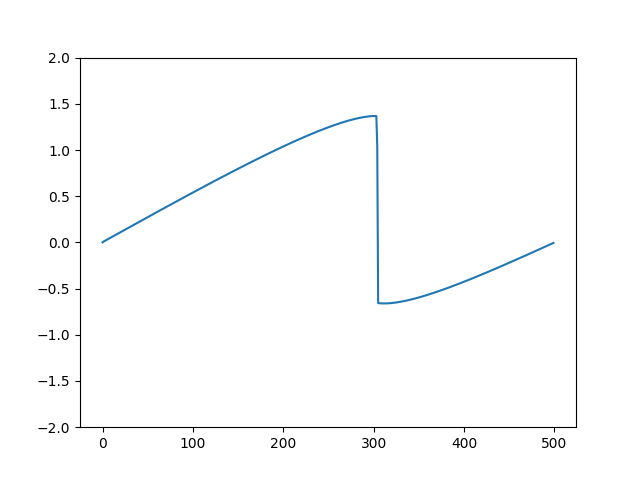

In [4]:
%matplotlib notebook

burgers = Burgers(method='Godunov')
animator = Animator(burgers=burgers)
animator.animate()


